In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [2]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

In [3]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
interv_df = pd.read_csv('outputs/interventions.csv')
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')
pilot_trans_df_small = pd.read_csv('outputs/pilot_transitions.csv')
pilot_trans_df = pd.read_csv('outputs/pilot_transitions_5months.csv')

In [4]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


(array([ 117.,  170.,  464.,  446.,  753., 1513., 1333., 1409., 2726.,
        5374.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

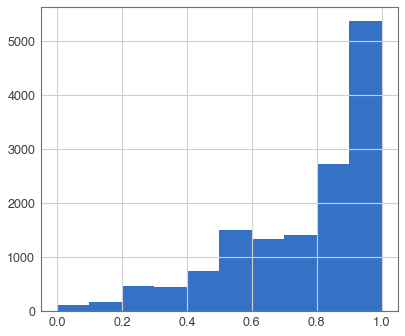

In [28]:
plt.hist(all_probs['P(L, N, L)'])

In [5]:
def get_transition_probabilities(beneficiaries, transitions, min_support=5):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}
user_probs, sup = get_transition_probabilities([pilot_user_ids[0]], pilot_trans_df)

all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm.tqdm(pilot_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], pilot_trans_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23008/23008 [03:17<00:00, 116.76it/s]


In [6]:
all_probs

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
0,2385611.0,NaN,NaN,NaN,NaN,0.944444,0.055556,NaN,NaN
1,2385612.0,NaN,NaN,NaN,NaN,NaN,NaN,0.176471,0.823529
2,2385613.0,NaN,NaN,NaN,NaN,0.571429,0.428571,0.214286,0.785714
3,2385614.0,NaN,NaN,NaN,NaN,NaN,NaN,0.176471,0.823529
4,2385615.0,NaN,NaN,NaN,NaN,0.800000,0.200000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
23003,2409132.0,NaN,NaN,NaN,NaN,NaN,NaN,0.105263,0.894737
23004,2409133.0,NaN,NaN,NaN,NaN,0.928571,0.071429,0.142857,0.857143
23005,2409134.0,NaN,NaN,NaN,NaN,0.500000,0.500000,0.384615,0.615385
23006,2409135.0,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.833333


In [7]:
all_probs[(~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
2,2385613.0,NaN,NaN,NaN,NaN,0.571429,0.428571,0.214286,0.785714
7,2385618.0,NaN,NaN,NaN,NaN,0.833333,0.166667,0.071429,0.928571
8,2385619.0,NaN,NaN,NaN,NaN,0.714286,0.285714,0.214286,0.785714
10,2385621.0,NaN,NaN,NaN,NaN,0.428571,0.571429,0.357143,0.642857
12,2385623.0,NaN,NaN,NaN,NaN,0.785714,0.214286,0.571429,0.428571
...,...,...,...,...,...,...,...,...,...
22998,2409127.0,NaN,NaN,NaN,NaN,0.875000,0.125000,0.076923,0.923077
22999,2409128.0,NaN,NaN,NaN,NaN,0.800000,0.200000,0.333333,0.666667
23002,2409131.0,NaN,NaN,NaN,NaN,1.000000,0.000000,0.200000,0.800000
23004,2409133.0,NaN,NaN,NaN,NaN,0.928571,0.071429,0.142857,0.857143


In [8]:
all_probs = pd.merge(all_probs, df[['user_id', 'cluster']])
all_probs

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)",cluster
0,2385611.0,NaN,NaN,NaN,NaN,0.944444,0.055556,NaN,NaN,3
1,2385612.0,NaN,NaN,NaN,NaN,NaN,NaN,0.176471,0.823529,35
2,2385613.0,NaN,NaN,NaN,NaN,0.571429,0.428571,0.214286,0.785714,3
3,2385614.0,NaN,NaN,NaN,NaN,NaN,NaN,0.176471,0.823529,35
4,2385615.0,NaN,NaN,NaN,NaN,0.800000,0.200000,NaN,NaN,27
...,...,...,...,...,...,...,...,...,...,...
22998,2409132.0,NaN,NaN,NaN,NaN,NaN,NaN,0.105263,0.894737,28
22999,2409133.0,NaN,NaN,NaN,NaN,0.928571,0.071429,0.142857,0.857143,35
23000,2409134.0,NaN,NaN,NaN,NaN,0.500000,0.500000,0.384615,0.615385,26
23001,2409135.0,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.833333,10


In [9]:
cluster_transition_probabilities

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.0,169.0,0.666667,0.333333,0.466667,0.533333,0.153001,0.846999,0.258012,0.741988
1,1.0,83.0,0.600000,0.400000,0.875000,0.125000,0.689132,0.310868,0.294719,0.705281
2,2.0,104.0,0.600000,0.400000,0.631579,0.368421,0.560425,0.439575,0.441054,0.558946
3,3.0,204.0,0.250000,0.750000,0.157895,0.842105,0.000000,1.000000,0.180547,0.819453
4,4.0,129.0,0.333333,0.666667,0.176471,0.823529,0.501182,0.498818,0.048505,0.951495
5,5.0,50.0,0.958333,0.041667,0.985655,0.014345,0.818342,0.181658,0.795455,0.204545
6,6.0,128.0,0.571429,0.428571,0.428571,0.571429,0.419136,0.580864,0.263838,0.736162
7,7.0,53.0,0.947368,0.052632,0.479162,0.520838,0.914069,0.085931,0.288961,0.711039
8,8.0,75.0,0.636364,0.363636,0.545455,0.454545,0.390496,0.609504,0.493551,0.506449
9,9.0,117.0,0.402725,0.597275,0.277778,0.722222,0.250526,0.749474,0.108681,0.891319


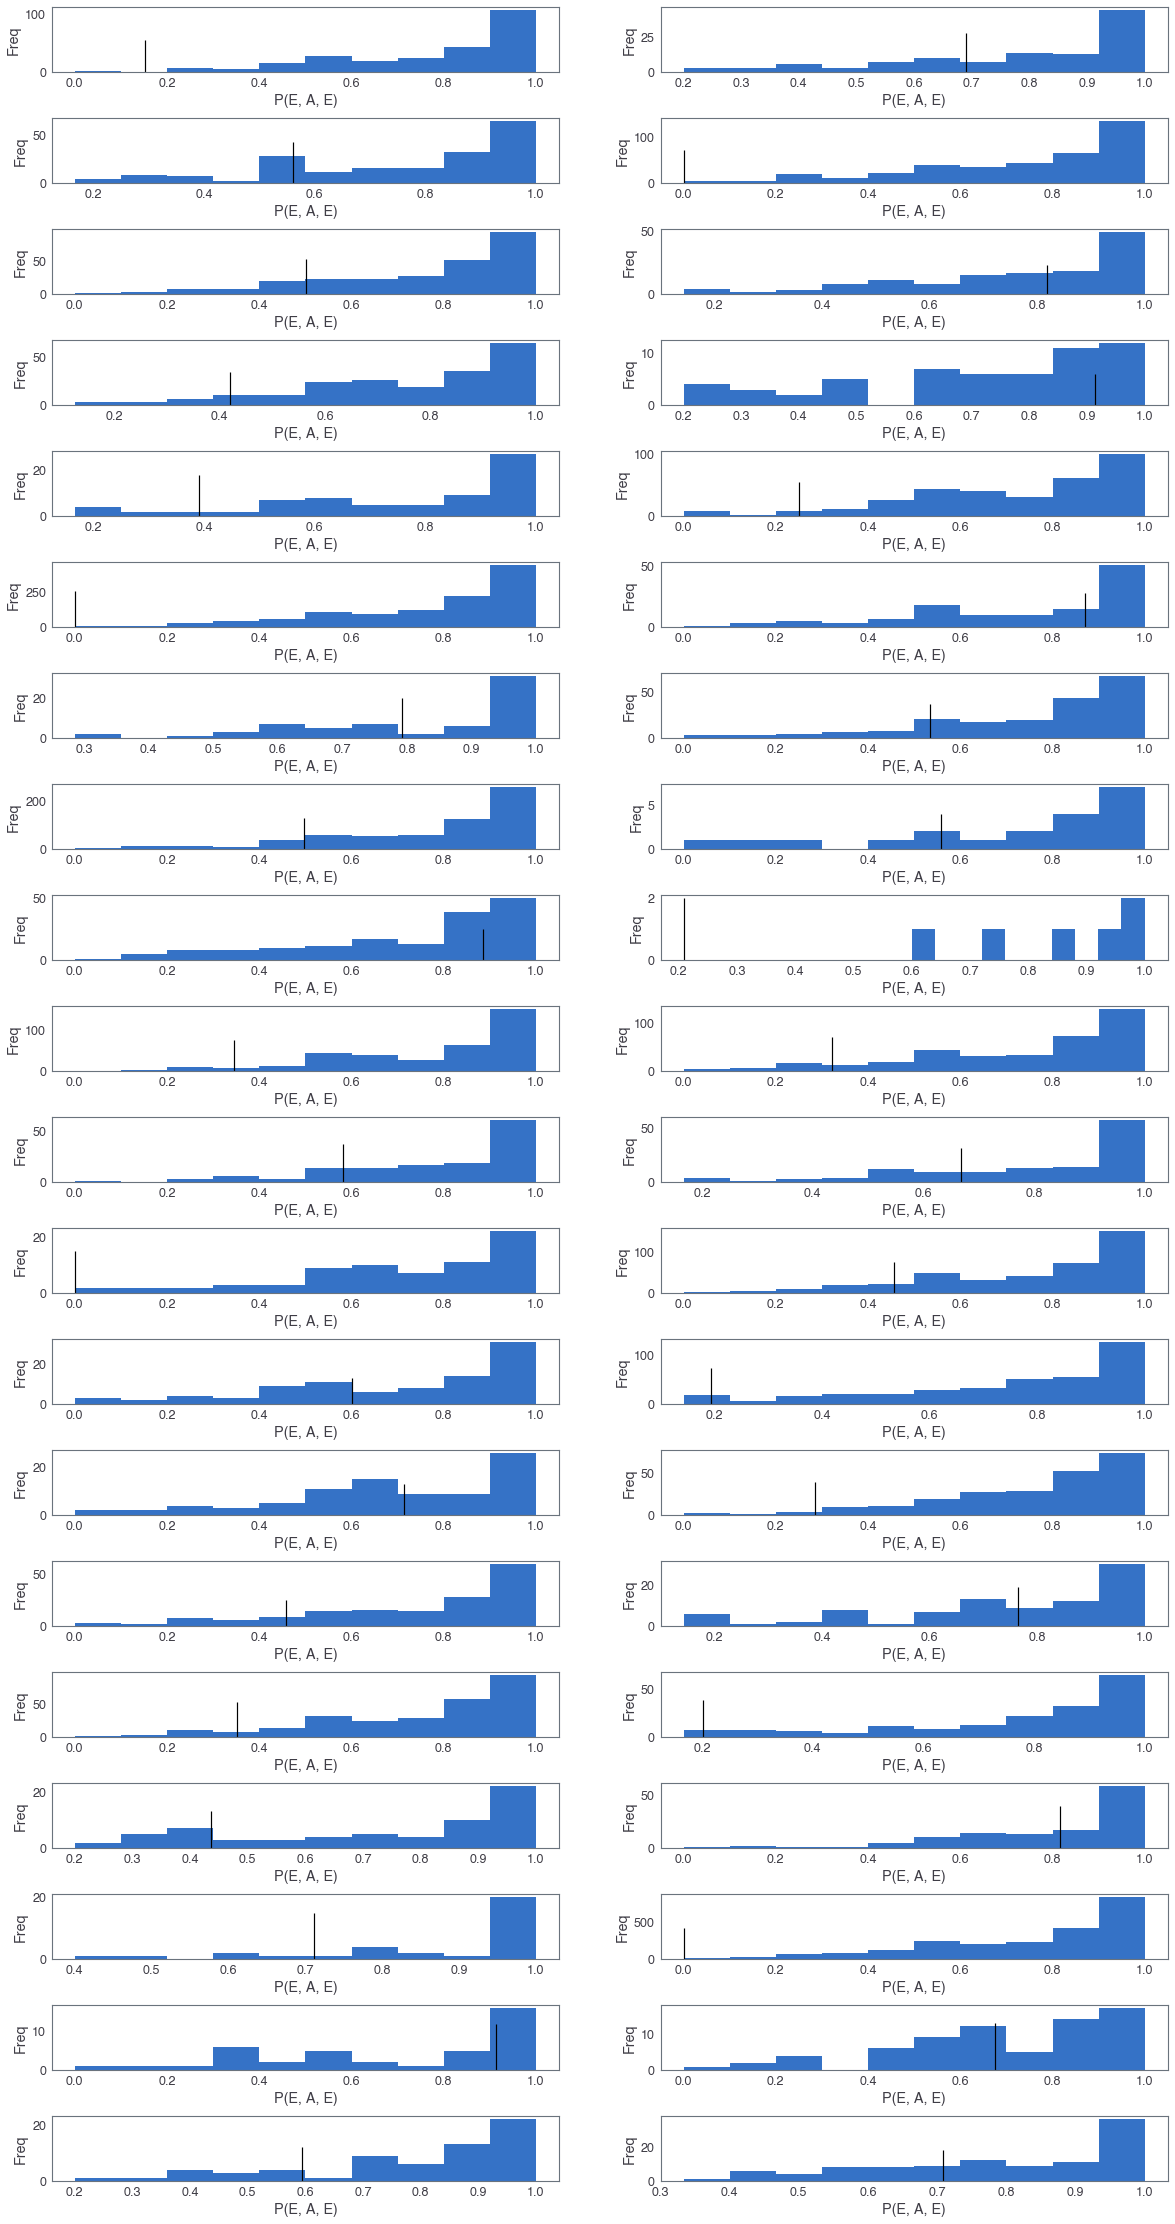

In [37]:
plt.figure(figsize=(20,40))
for cluster in range(40):
    plt.subplot(20, 2, cluster+1)
    plt.hist(all_probs[(all_probs['cluster']==cluster) &
                         (~all_probs.user_id.isin(interv_df.user_id))]['P(L, N, L)'])
    pred_prob = cluster_transition_probabilities[cluster_transition_probabilities.cluster==cluster]['P(E, A, E)'] 
#     print(pred_prob)
    ymax = all_probs[(all_probs['cluster']==cluster) &
                         (~all_probs.user_id.isin(interv_df.user_id))]['P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
    plt.grid(b=None)
    plt.xlabel('P(E, A, E)')
    plt.ylabel('Freq')
    plt.subplots_adjust(
                    hspace=0.7, 
                    )
plt.show()

In [376]:
np.unique(interv_df.user_id).shape

(6005,)

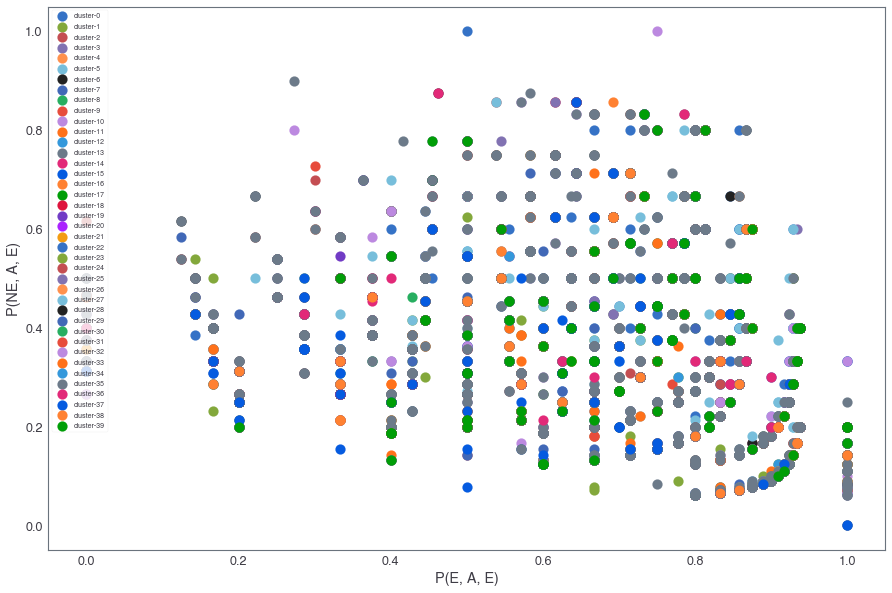

In [38]:
import seaborn as sns
plt.figure(figsize=(15, 10))
for cluster in range(40):
    plt.scatter(all_probs[all_probs['cluster']==cluster]['P(L, N, L)'],
                all_probs[all_probs['cluster']==cluster]['P(H, N, L)'],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)

In [378]:
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# for cluster in range(40):
#     sub = all_probs[(all_probs['cluster']==cluster) &
#                          (~all_probs.user_id.isin(interv_df.user_id))]
#     if len(sub)<500:
#         continue
#     plt.scatter(sub['P(L, N, L)']+np.random.uniform(-0.01, 0.01, sub.shape[0]),
#                 sub['P(H, N, L)']+np.random.uniform(-0.01, 0.01, sub.shape[0]),
#                 label=f'cluster-{cluster}', s=10, alpha=0.9)
# plt.grid(b=None)
# plt.legend(fontsize=7)

In [82]:
def kmeans_missing(X, n_clusters, max_iter=10):
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    prev_labels = None
    for i in range(max_iter):
        cls = KMeans(n_clusters, n_jobs=-1, random_state=0)


        labels = cls.fit_predict(X_hat)

        centroids = cls.cluster_centers_


        X_hat[missing] = centroids[labels][missing]

        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels

    return labels, centroids, X_hat, cls, len(set(labels)), i


In [186]:
### if want to use kmeans missing

# X = all_probs[['P(L, N, L)', 'P(H, N, L)']]
# n_clusters = 40
# out =  kmeans_missing(X, n_clusters) 
# labels, centroids, X_hat, kmeans_new, _, _ = out

# X = pd.DataFrame(X_hat, columns=X.columns)
# X['fitted_cluster'] = labels

In [187]:
from sklearn.cluster import KMeans
import numpy as np
X = all_probs[['P(L, N, L)', 'P(H, N, L)']].dropna()
n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
kmeans.labels_
X['fitted_cluster'] = kmeans.labels_
X
# kmeans.cluster_centers_

,"P(L, N, L)","P(H, N, L)",fitted_cluster
2,0.571429,0.214286,16
7,0.833333,0.071429,6
8,0.714286,0.214286,17
10,0.428571,0.357143,2
12,0.785714,0.571429,30
...,...,...,...
22993,0.875000,0.076923,35
22994,0.800000,0.333333,3
22997,1.000000,0.200000,7
22999,0.928571,0.142857,25


(10159, 3)


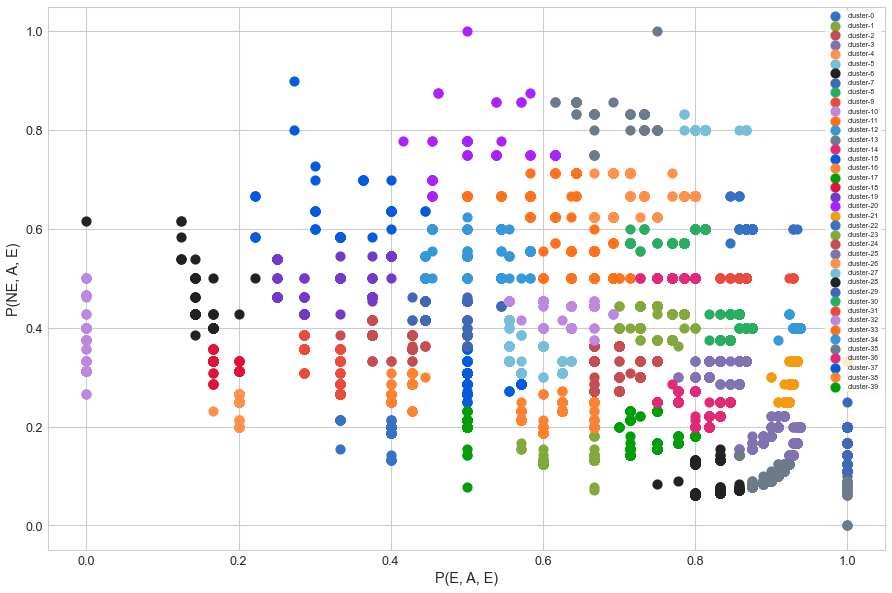

In [188]:
import seaborn as sns
plt.figure(figsize=(15, 10))
print(X.shape)
for cluster in range(n_clusters):
    plt.scatter(X[X['fitted_cluster']==cluster].iloc[:, 0],
                X[X['fitted_cluster']==cluster].iloc[:, 1],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)

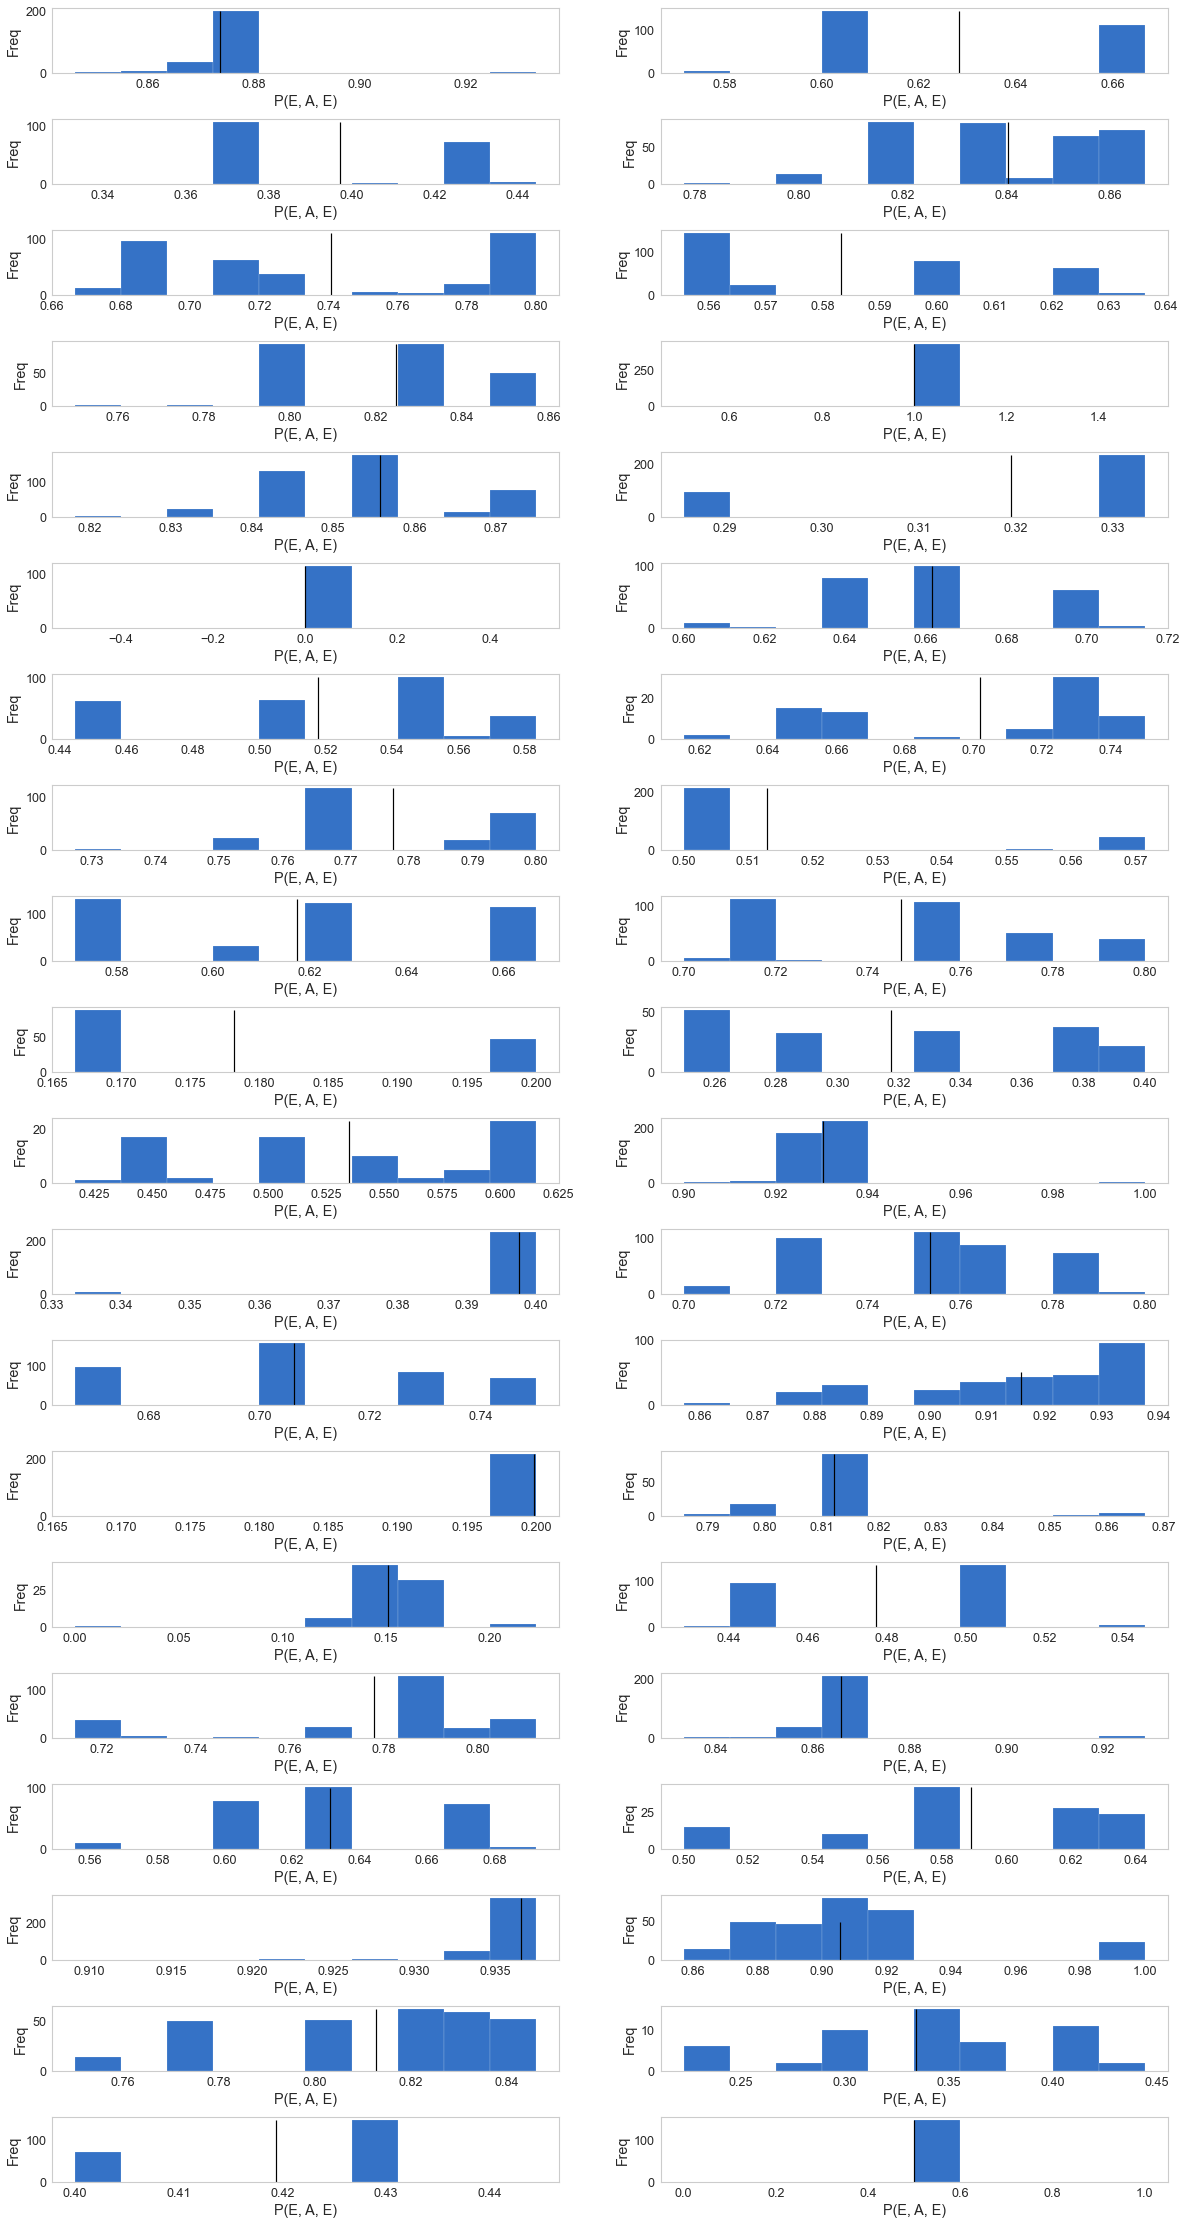

In [189]:
plt.figure(figsize=(20,40))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(X[X.fitted_cluster==cluster]['P(L, N, L)'])
    
    pred_prob = kmeans.cluster_centers_[cluster, 0]
#     pred_prob = centroids[cluster, 0]
    
    ymax = X[X.fitted_cluster==cluster]['P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
    plt.xlabel('P(E, A, E)')
    plt.ylabel('Freq')
    plt.subplots_adjust(
                    hspace=0.7, 
                    )
# plt.grid(b=None)
plt.show()

80 % 20% -> A, B

clustering on A -> ylabels

SPlit A in 80% and 20% we will get A_train, A_test

classifier is trained on A_train, tested on A_tested -> 7%

train classifier on full A
use classifier to predict cluster centres for B using B features
get probablities using predicted cluster centres

for B: predicted TP and true transition TP



In [190]:
probs = all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']].dropna()
# probs = all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']]
feats = pd.DataFrame(pilot_static_features)
feats.columns = [f'feat-{i}' for i in range(pilot_static_features.shape[1])]
feats['user_id'] = pilot_user_ids
feats
data_df = pd.merge(all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']].dropna(),
                      feats)
# data_df = pd.merge(all_probs[['user_id', 'P(L, N, L)', 'P(H, N, L)']],
#                       feats)
data_df


,user_id,"P(L, N, L)","P(H, N, L)",feat-0,feat-1,feat-2,feat-3,feat-4,feat-5,feat-6,...,feat-34,feat-35,feat-36,feat-37,feat-38,feat-39,feat-40,feat-41,feat-42,feat-43
0,2385613.0,0.571429,0.214286,-9.579494,0.0,2.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2385618.0,0.833333,0.071429,11.420506,0.0,3.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2385619.0,0.714286,0.214286,-15.579494,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2385621.0,0.428571,0.357143,-2.579494,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2385623.0,0.785714,0.571429,9.420506,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10154,2409127.0,0.875000,0.076923,15.420506,0.0,2.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10155,2409128.0,0.800000,0.333333,5.420506,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10156,2409131.0,1.000000,0.200000,-2.579494,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10157,2409133.0,0.928571,0.142857,18.420506,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [191]:
n = data_df.shape[0]
shuffled = pd.Series(data_df.index).sample(frac=1).values
train_idx, test_idx = shuffled[:int(n*0.8)],\
                               shuffled[int(n*0.8):]


In [192]:
###If wanna use kmeans missing

# X = data_df.loc[train_idx]
# n_clusters = 40
# out =  kmeans_missing(X[['P(L, N, L)', 'P(H, N, L)']], n_clusters) 
# labels, centroids, X_hat, kmeans_new, _, _ = out

# X[['P(L, N, L)', 'P(H, N, L)']] = X_hat
# X['fitted_cluster'] = labels

In [193]:
from sklearn.cluster import KMeans
import numpy as np
X = data_df.loc[train_idx].dropna()
n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X[['P(L, N, L)', 'P(H, N, L)']])
kmeans.labels_
X['fitted_cluster'] = kmeans.labels_
X
# kmeans.cluster_centers_

,user_id,"P(L, N, L)","P(H, N, L)",feat-0,feat-1,feat-2,feat-3,feat-4,feat-5,feat-6,...,feat-35,feat-36,feat-37,feat-38,feat-39,feat-40,feat-41,feat-42,feat-43,fitted_cluster
3859,2395524.0,0.933333,0.400000,-5.579494,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5
8308,2405872.0,0.400000,0.250000,-6.579494,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26
7186,2403601.0,0.923077,0.125000,18.420506,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
4736,2397598.0,0.500000,0.545455,-8.579494,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7
8659,2406539.0,0.285714,0.357143,18.420506,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,2396206.0,0.909091,0.200000,-6.579494,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
10017,2408905.0,1.000000,0.200000,-12.579494,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
7908,2405067.0,0.750000,0.230769,-8.579494,0.0,3.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
1444,2389256.0,0.923077,0.142857,-6.579494,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2


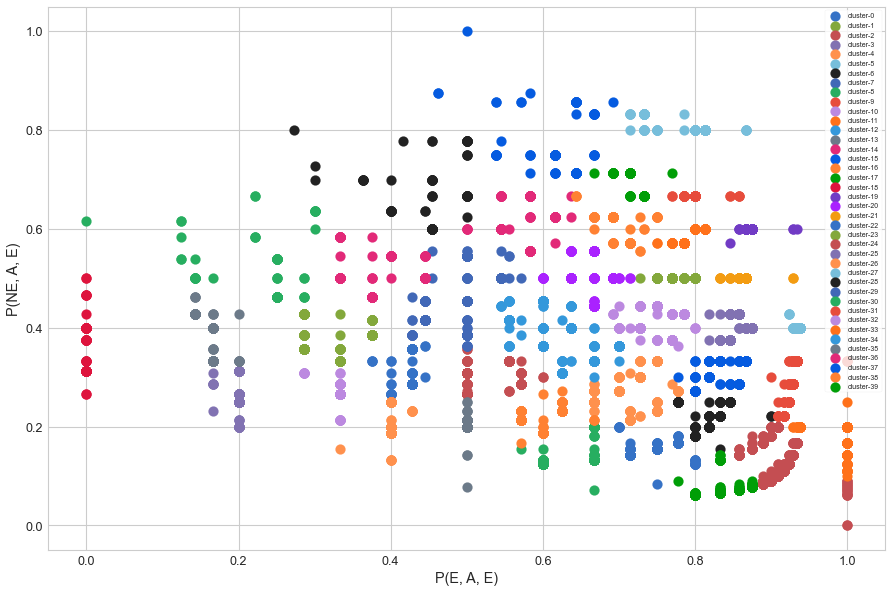

In [194]:
import seaborn as sns
plt.figure(figsize=(15, 10))
for cluster in range(n_clusters):
    plt.scatter(X[X['fitted_cluster']==cluster].iloc[:, 1],
                X[X['fitted_cluster']==cluster].iloc[:, 2],
                label=f'cluster-{cluster}', s=100)
plt.xlabel('P(E, A, E)')
plt.ylabel('P(NE, A, E)')
plt.grid(b=None)
plt.legend(fontsize=7)

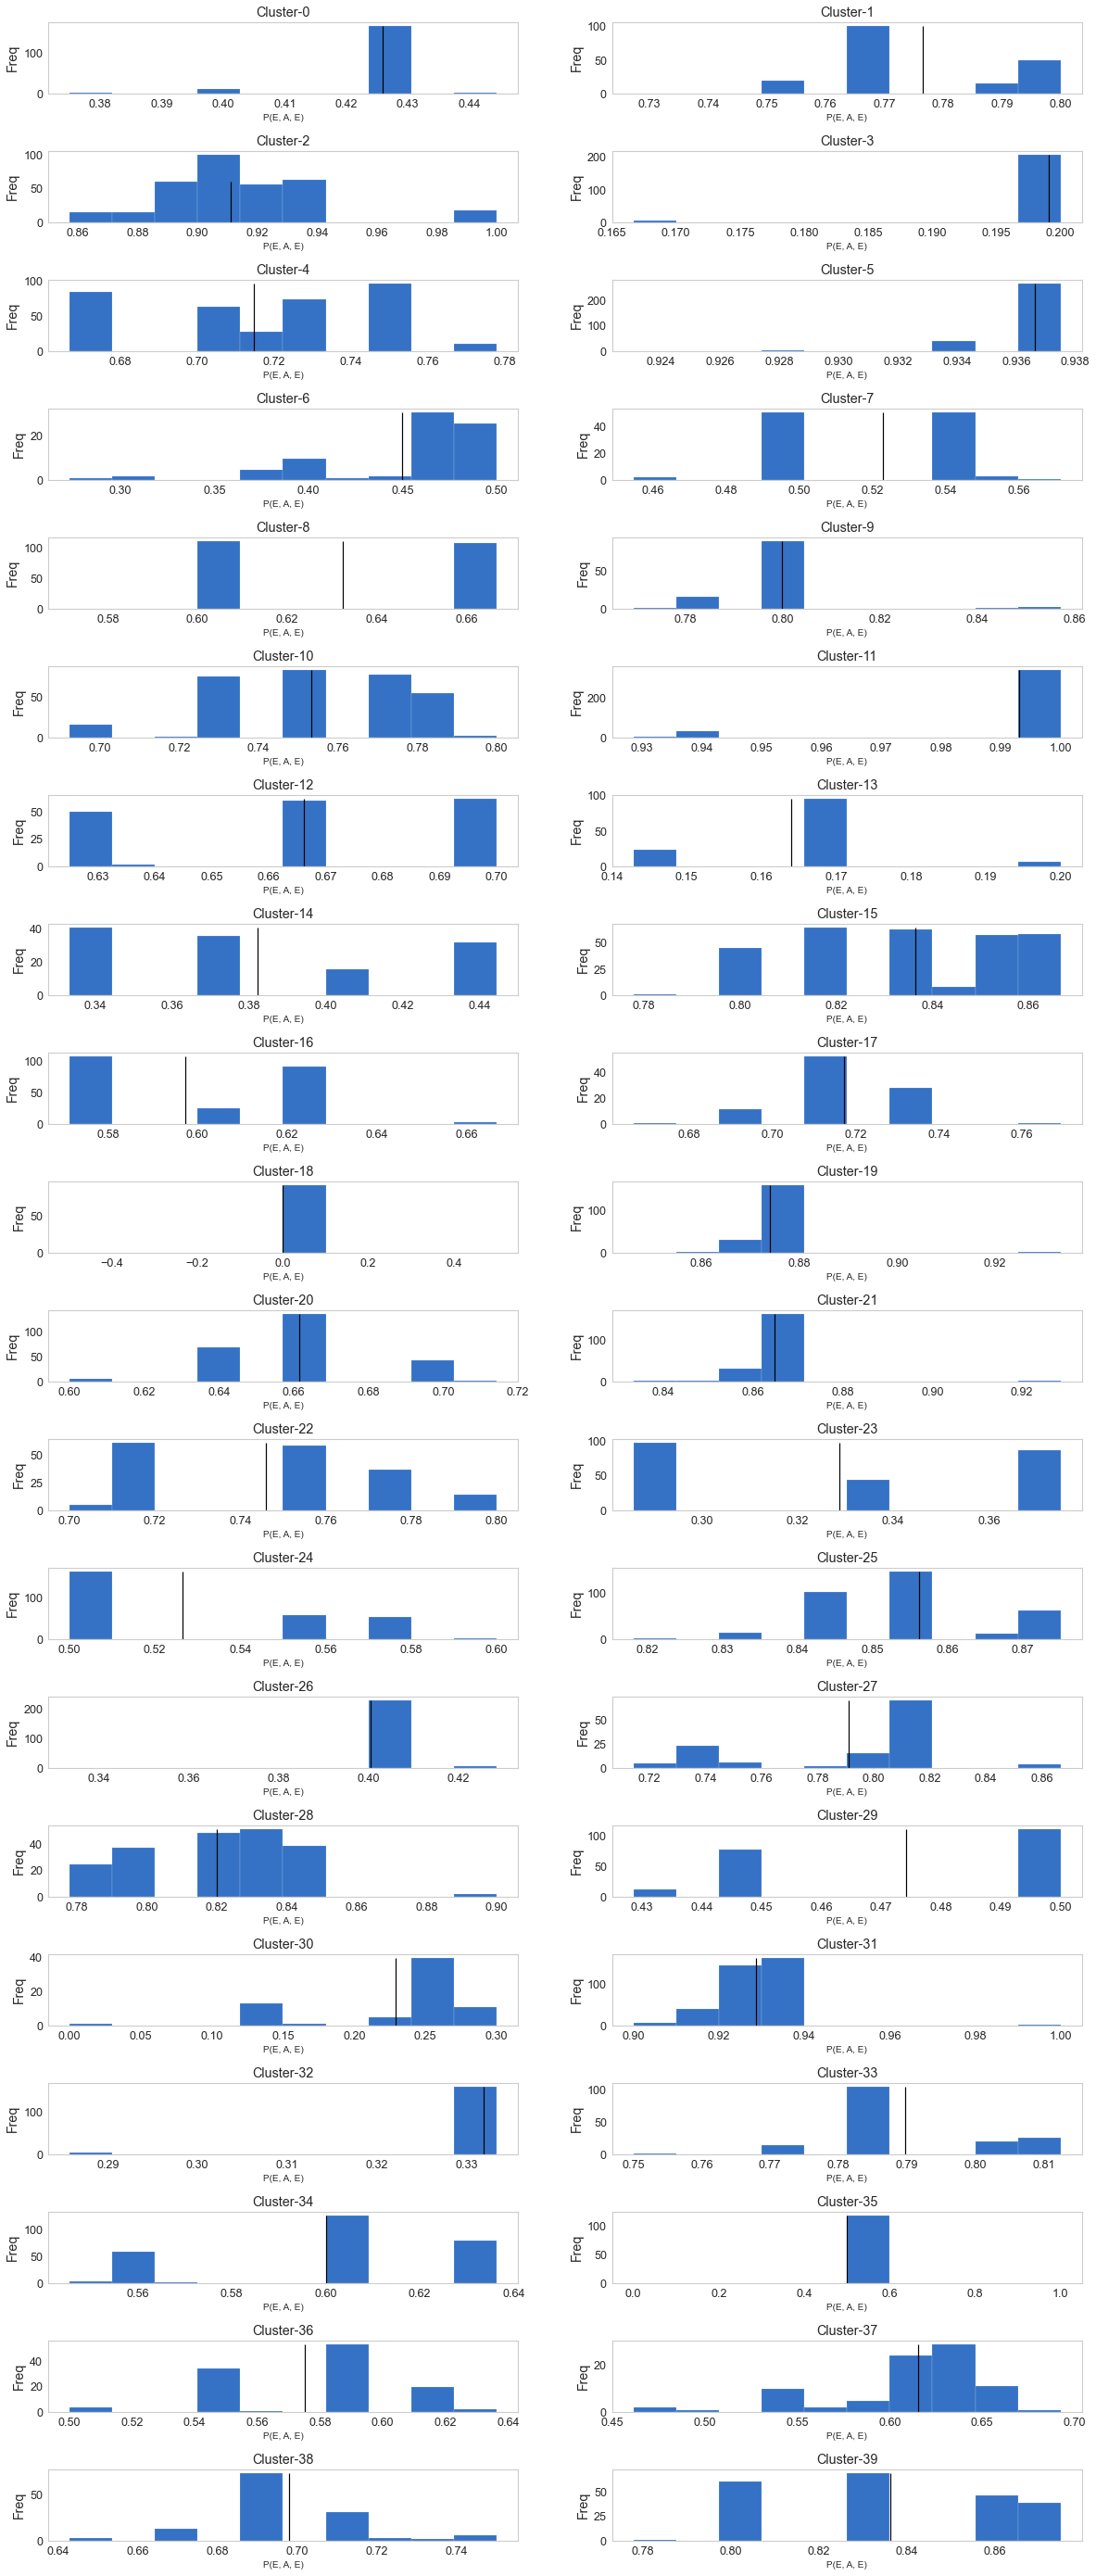

In [215]:
plt.figure(figsize=(20,50))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(X[X.fitted_cluster==cluster]['P(L, N, L)'])
#     print()
    pred_prob = kmeans.cluster_centers_[cluster, 0]
#     pred_prob = centroids[cluster, 0]
    
    ymax = X[X.fitted_cluster==cluster]['P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='black')
    plt.xlabel('P(E, A, E)', fontsize=10)
    plt.ylabel('Freq')
    plt.gca().set_title(f'Cluster-{cluster}')
    plt.subplots_adjust(
                    hspace=0.8, 
                    )
# plt.grid(b=None)
# plt.title('Train Clusters Transition Probablity Distributions')
plt.show()

In [200]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X, X.iloc[:, -1]):
    dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=30, n_jobs=-1, random_state=124)
#     dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=7, n_jobs=-1, random_state=124)
#     dt_clf = LGBMClassifier(n_estimators=100, max_depth=3)
    dt_clf.fit(X.iloc[train_index, 3:-1], X.iloc[train_index, -1])
    print('test acc: ', dt_clf.score(X.iloc[test_index, 3:-1], X.iloc[test_index, -1]), \
    'train acc: ', dt_clf.score(X.iloc[train_index, 3:-1], X.iloc[train_index, -1]))


test acc:  0.03505535055350553 train acc:  0.971696662051992
test acc:  0.04428044280442804 train acc:  0.9724657744962314
test acc:  0.033210332103321034 train acc:  0.9715428395631441
test acc:  0.037515375153751536 train acc:  0.9707737271189048
test acc:  0.03505535055350553 train acc:  0.9710813720966005


In [201]:
# dt_clf = LGBMClassifier(n_estimators=100, max_depth=3)
dt_clf = LGBMClassifier(n_estimators=200, max_depth=5)

# dt_clf = LGBMClassifier(**study.best_params)
# dt_clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=3, n_jobs=-1, random_state=124)


# dt_clf = RandomForestClassifier(n_estimators=200, criterion="entropy", max_depth=30, n_jobs=-1, random_state=124)

dt_clf.fit(X.iloc[:, 3:-1], X.iloc[:, -1])


LGBMClassifier(max_depth=5, n_estimators=200)

In [202]:
pred_clusters = dt_clf.predict(data_df.iloc[test_idx, 3:])
print(np.unique(pred_clusters))
pred_probs = X[['P(L, N, L)', 'P(H, N, L)', 'fitted_cluster']].groupby('fitted_cluster').mean().loc[pred_clusters]   
tru_probs = data_df.iloc[test_idx, 1:3]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [203]:
diff = (tru_probs.reset_index().iloc[:, 1:] - pred_probs.reset_index().iloc[:, 1:])
np.sqrt(np.square(diff).mean(axis=0))


P(L, N, L)    0.294211
P(H, N, L)    0.226015
dtype: float64

In [205]:
diff = tru_probs.reset_index().iloc[:, 1:] - np.random.uniform(0, 1, tru_probs.shape)
np.sqrt(np.square(diff).mean(axis=0))


P(L, N, L)    0.411179
P(H, N, L)    0.371095
dtype: float64

In [196]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::pyerfa==1.7.3=py38h9ed2024_0
  - defaults/osx-64::pywavelets==1.1.1=py38haf1e3a3_2
  - defaults/osx-64::bokeh==2.3.2=py38hecd8cb5_0
  - defaults/noarch::imageio==2.9.0=pyhd3eb1b0_0
  - defaults/osx-64::matplotlib==3.3.4=py38hecd8cb5_0
  - defaults/osx-64::bottleneck==1.3.2=py38hf1fa96c_1
  - defaults/osx-64::scikit-image==0.18.1=py38hb2f4e1b_0
  - defaults/osx-64::distributed==2021.4.0=py38hecd8cb5_0
  - defaults/osx-64::mkl_fft==1.3.0=py38h4a7008c_2
  - defaults/osx-64::conda-package-handling==1.7.3=py38h9ed2024_1
  - defaults/osx-64::anaconda-navigator==2.0.3=py38_0
  - defaults/osx-64::numba==0.53.1=py38hb2f4e1b_0
  - defaults/osx-64::numpy==1.20.1=py38hd6e1bb9_0
  - defaults/osx-64::patsy==0.5.1=py38_0
  - defaults/osx-64::astropy==4.2.1=py38h9ed2024_1
  - defaults/noarch::nltk==3.6.1=pyhd3eb1b0_0
  - defaults/n

In [289]:
!pip install optuna

     |████████████████████████████████| 308 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 209 kB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 144 kB 25.9 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 15.2 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=4502ded2b53538f6ade61619e39c2be80d33147f493c7142272d4821dbccc22f
  Stored in directory: /Users/vermashresth/Library/Caches/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [428]:
from optuna.integration import LightGBMPruningCallback

import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 1, 7),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective= 'multiclass', **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=20,
#             callbacks=[
#                 LightGBMPruningCallback(trial, "binary_logloss")
#             ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds, labels=list(range(40)))

    return -np.mean(cv_scores)

In [431]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial,
                               X.iloc[:, 3:-1], X.iloc[:, -1])
study.optimize(func, n_trials=10)

[I 2021-10-18 20:12:19,303] A new study created in memory with name: LGBM Classifier
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=3.9186953946393266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9186953946393266
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[1]	valid_0's multi_logloss: 3.67141
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67141
[3]	valid_0's multi_logloss: 3.67

[I 2021-10-18 20:12:19,636] Trial 0 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.07991619625061974, 'num_leaves': 160, 'max_depth': 4, 'min_data_in_leaf': 9100, 'lambda_l1': 60, 'lambda_l2': 20, 'min_gain_to_split': 3.9186953946393266, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: -3.581486765723222.


[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=3.9186953946393266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9186953946393266
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[1]	valid_0's multi_logloss: 3.67234
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67234
[3]	valid_0's multi_logloss: 3.67234
[4]	valid_0's multi_logloss: 3.67234
[5]	valid_0's multi_logloss: 3.67234
[6]	valid_0's multi_logloss: 3.67234
[7]	valid_0's multi_logloss: 3.67234
[8]	valid_0's multi_logloss: 3.67234
[9]	valid_0's multi_logloss: 3.67234
[10]	valid_0's multi_logloss: 3.67234
[11]	valid_0's multi_logloss: 3.67234
[12]	valid_0's multi_logloss: 3.67234
[13]	valid_0's multi_logloss: 3.67234
[14]	valid_0's multi_logloss: 3.67234
[15]	valid_0's multi_logloss: 3.67234
[16]	v

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-10-18 20:12:19,923] Trial 1 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.21669998374829683, 'num_leaves': 960, 'max_depth': 6, 'min_data_in_leaf': 9500, 'lambda_l1': 15, 'lambda_l2': 90, 'min_gain_to_split': 6.988214218714092, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: -3.581486765723222.


[5]	valid_0's multi_logloss: 3.67066
[6]	valid_0's multi_logloss: 3.67066
[7]	valid_0's multi_logloss: 3.67066
[8]	valid_0's multi_logloss: 3.67066
[9]	valid_0's multi_logloss: 3.67066
[10]	valid_0's multi_logloss: 3.67066
[11]	valid_0's multi_logloss: 3.67066
[12]	valid_0's multi_logloss: 3.67066
[13]	valid_0's multi_logloss: 3.67066
[14]	valid_0's multi_logloss: 3.67066
[15]	valid_0's multi_logloss: 3.67066
[16]	valid_0's multi_logloss: 3.67066
[17]	valid_0's multi_logloss: 3.67066
[18]	valid_0's multi_logloss: 3.67066
[19]	valid_0's multi_logloss: 3.67066
[20]	valid_0's multi_logloss: 3.67066
[21]	valid_0's multi_logloss: 3.67066
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.3455485826883407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3455485826883407
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[1]	valid_0's multi_logloss: 3.67141
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67141
[3]	valid_0's multi_logloss: 3.

[I 2021-10-18 20:12:20,304] Trial 2 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.11020695985448473, 'num_leaves': 2480, 'max_depth': 7, 'min_data_in_leaf': 4500, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 1.3455485826883407, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: -3.581486765723222.


[18]	valid_0's multi_logloss: 3.67083
[19]	valid_0's multi_logloss: 3.67083
[20]	valid_0's multi_logloss: 3.67083
[21]	valid_0's multi_logloss: 3.67083
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=1.3455485826883407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3455485826883407
[LightGBM] [Warning] lambda_l1 is set=50, r

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[11]	valid_0's multi_logloss: 3.67141
[12]	valid_0's multi_logloss: 3.67141
[13]	valid_0's multi_logloss: 3.67141
[14]	valid_0's multi_logloss: 3.67141
[15]	valid_0's multi_logloss: 3.67141
[16]	valid_0's multi_logloss: 3.67141
[17]	valid_0's multi_logloss: 3.67141
[18]	valid_0's multi_logloss: 3.67141
[19]	valid_0's multi_logloss: 3.67141
[20]	valid_0's multi_logloss: 3.67141
[21]	valid_0's multi_logloss: 3.67141
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.2, 

[I 2021-10-18 20:12:20,595] Trial 3 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.18601277656308413, 'num_leaves': 1140, 'max_depth': 3, 'min_data_in_leaf': 7200, 'lambda_l1': 85, 'lambda_l2': 50, 'min_gain_to_split': 1.1060219348487188, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -3.581486765723222.


[1]	valid_0's multi_logloss: 3.67286
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67286
[3]	valid_0's multi_logloss: 3.67286
[4]	valid_0's multi_logloss: 3.67286
[5]	valid_0's multi_logloss: 3.67286
[6]	valid_0's multi_logloss: 3.67286
[7]	valid_0's multi_logloss: 3.67286
[8]	valid_0's multi_logloss: 3.67286
[9]	valid_0's multi_logloss: 3.67286
[10]	valid_0's multi_logloss: 3.67286
[11]	valid_0's multi_logloss: 3.67286
[12]	valid_0's multi_logloss: 3.67286
[13]	valid_0's multi_logloss: 3.67286
[14]	valid_0's multi_logloss: 3.67286
[15]	valid_0's multi_logloss: 3.67286
[16]	valid_0's multi_logloss: 3.67286
[17]	valid_0's multi_logloss: 3.67286
[18]	valid_0's multi_logloss: 3.67286
[19]	valid_0's multi_logloss: 3.67286
[20]	valid_0's multi_logloss: 3.67286
[21]	valid_0's multi_logloss: 3.67286
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. 

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-10-18 20:12:20,892] Trial 4 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.16156729863431762, 'num_leaves': 440, 'max_depth': 4, 'min_data_in_leaf': 5800, 'lambda_l1': 95, 'lambda_l2': 15, 'min_gain_to_split': 11.67833811676035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: -3.581486765723222.


[6]	valid_0's multi_logloss: 3.67083
[7]	valid_0's multi_logloss: 3.67083
[8]	valid_0's multi_logloss: 3.67083
[9]	valid_0's multi_logloss: 3.67083
[10]	valid_0's multi_logloss: 3.67083
[11]	valid_0's multi_logloss: 3.67083
[12]	valid_0's multi_logloss: 3.67083
[13]	valid_0's multi_logloss: 3.67083
[14]	valid_0's multi_logloss: 3.67083
[15]	valid_0's multi_logloss: 3.67083
[16]	valid_0's multi_logloss: 3.67083
[17]	valid_0's multi_logloss: 3.67083
[18]	valid_0's multi_logloss: 3.67083
[19]	valid_0's multi_logloss: 3.67083
[20]	valid_0's multi_logloss: 3.67083
[21]	valid_0's multi_logloss: 3.67083
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: l

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.999135409263207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.999135409263207
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[1]	valid_0's multi_logloss: 3.67066
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67066
[3]	v

[I 2021-10-18 20:12:21,193] Trial 5 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.030436050707841437, 'num_leaves': 1920, 'max_depth': 6, 'min_data_in_leaf': 7900, 'lambda_l1': 25, 'lambda_l2': 70, 'min_gain_to_split': 7.999135409263207, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: -3.581486765723222.


[7]	valid_0's multi_logloss: 3.67286
[8]	valid_0's multi_logloss: 3.67286
[9]	valid_0's multi_logloss: 3.67286
[10]	valid_0's multi_logloss: 3.67286
[11]	valid_0's multi_logloss: 3.67286
[12]	valid_0's multi_logloss: 3.67286
[13]	valid_0's multi_logloss: 3.67286
[14]	valid_0's multi_logloss: 3.67286
[15]	valid_0's multi_logloss: 3.67286
[16]	valid_0's multi_logloss: 3.67286
[17]	valid_0's multi_logloss: 3.67286
[18]	valid_0's multi_logloss: 3.67286
[19]	valid_0's multi_logloss: 3.67286
[20]	valid_0's multi_logloss: 3.67286
[21]	valid_0's multi_logloss: 3.67286
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feat

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-10-18 20:12:21,527] Trial 6 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.1192956358171511, 'num_leaves': 2840, 'max_depth': 3, 'min_data_in_leaf': 6800, 'lambda_l1': 60, 'lambda_l2': 55, 'min_gain_to_split': 6.075254994994038, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: -3.581486765723222.


[7]	valid_0's multi_logloss: 3.67083
[8]	valid_0's multi_logloss: 3.67083
[9]	valid_0's multi_logloss: 3.67083
[10]	valid_0's multi_logloss: 3.67083
[11]	valid_0's multi_logloss: 3.67083
[12]	valid_0's multi_logloss: 3.67083
[13]	valid_0's multi_logloss: 3.67083
[14]	valid_0's multi_logloss: 3.67083
[15]	valid_0's multi_logloss: 3.67083
[16]	valid_0's multi_logloss: 3.67083
[17]	valid_0's multi_logloss: 3.67083
[18]	valid_0's multi_logloss: 3.67083
[19]	valid_0's multi_logloss: 3.67083
[20]	valid_0's multi_logloss: 3.67083
[21]	valid_0's multi_logloss: 3.67083
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feat

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[1]	valid_0's multi_logloss: 3.67141
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67141
[3]	valid_0's multi_logloss: 3.67141
[4]	valid_0's multi_logloss: 3.67141
[5]	valid_0's multi_logloss: 3.67141
[6]	valid_0's multi_logloss: 3.67141
[7]	valid_0's multi_logloss: 3.67141
[8]	valid_0's multi_logloss: 3.67141
[9]	valid_0's multi_logloss: 3.67141
[10]	valid_0's multi_logloss: 3.67141
[11]	valid_0's multi_logloss: 3.67141
[12]	valid_0's multi_logloss: 3.67141
[13]	valid_0's multi_logloss: 3.67141
[14]	valid_0's multi_logloss: 3.67141
[15]	valid_0's multi_logloss: 3.67141
[16]	valid_0's multi_logloss: 3.67141
[17]	valid_0's multi_logloss: 3.67141
[18]	valid_0's multi_logloss: 3.67141
[19]	valid_0's multi_logloss: 3.67141
[20]	valid_0's multi_logloss: 3.67141
[21]	valid_0's multi_logloss: 3.67141
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. 

[I 2021-10-18 20:12:22,388] Trial 7 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.2614356070923105, 'num_leaves': 1920, 'max_depth': 4, 'min_data_in_leaf': 2100, 'lambda_l1': 65, 'lambda_l2': 70, 'min_gain_to_split': 11.66642549177251, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: -3.581486765723222.


[5]	valid_0's multi_logloss: 3.67234
[6]	valid_0's multi_logloss: 3.67234
[7]	valid_0's multi_logloss: 3.67234
[8]	valid_0's multi_logloss: 3.67234
[9]	valid_0's multi_logloss: 3.67234
[10]	valid_0's multi_logloss: 3.67234
[11]	valid_0's multi_logloss: 3.67234
[12]	valid_0's multi_logloss: 3.67234
[13]	valid_0's multi_logloss: 3.67234
[14]	valid_0's multi_logloss: 3.67234
[15]	valid_0's multi_logloss: 3.67234
[16]	valid_0's multi_logloss: 3.67234
[17]	valid_0's multi_logloss: 3.67234
[18]	valid_0's multi_logloss: 3.67234
[19]	valid_0's multi_logloss: 3.67234
[20]	valid_0's multi_logloss: 3.67234
[21]	valid_0's multi_logloss: 3.67234
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.624461892256566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.624461892256566
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[1]	valid_0's multi_logloss: 3.67141
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67141
[3]

[I 2021-10-18 20:12:23,092] Trial 8 finished with value: -3.5814688841226996 and parameters: {'n_estimators': 500, 'learning_rate': 0.14108330918517628, 'num_leaves': 500, 'max_depth': 2, 'min_data_in_leaf': 800, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 14.624461892256566, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -3.581486765723222.


[7]	valid_0's multi_logloss: 3.67286
[8]	valid_0's multi_logloss: 3.67286
[9]	valid_0's multi_logloss: 3.67286
[10]	valid_0's multi_logloss: 3.67286
[11]	valid_0's multi_logloss: 3.67286
[12]	valid_0's multi_logloss: 3.67286
[13]	valid_0's multi_logloss: 3.67286
[14]	valid_0's multi_logloss: 3.67286
[15]	valid_0's multi_logloss: 3.67286
[16]	valid_0's multi_logloss: 3.67286
[17]	valid_0's multi_logloss: 3.67286
[18]	valid_0's multi_logloss: 3.67286
[19]	valid_0's multi_logloss: 3.67286
[20]	valid_0's multi_logloss: 3.67286
[21]	valid_0's multi_logloss: 3.67286
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 3.67286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feat

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  warnings.warn(
[I 2021-10-18 20:12:23,411] Trial 9 finished with value: -3.581486765723222 and parameters: {'n_estimators': 500, 'learning_rate': 0.11620375389382201, 'num_leaves': 2940, 'max_depth': 7, 'min_data_in_leaf': 7500, 'lambda_l1': 15, 'lambda_l2': 10, 'min_gain_to_split': 12.23534016661508, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: -3.581486765723222.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=12.23534016661508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.23534016661508
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[1]	valid_0's multi_logloss: 3.67083
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 3.67083
[3]	valid_0's multi_logloss: 3.6708

In [432]:
study.best_params

{'n_estimators': 500,
 'learning_rate': 0.07991619625061974,
 'num_leaves': 160,
 'max_depth': 4,
 'min_data_in_leaf': 9100,
 'lambda_l1': 60,
 'lambda_l2': 20,
 'min_gain_to_split': 3.9186953946393266,
 'bagging_fraction': 0.2,
 'bagging_freq': 1,
 'feature_fraction': 0.2}

In [206]:
plot_df = pred_probs.reset_index()
plot_df['tru-P(L, N, L)'] = tru_probs.iloc[:, 0].values
plot_df['tru-P(H, N, L)'] = tru_probs.iloc[:, 1].values
plot_df

,fitted_cluster,"P(L, N, L)","P(H, N, L)","tru-P(L, N, L)","tru-P(H, N, L)"
0,19,0.874077,0.599856,0.727273,0.300000
1,25,0.856185,0.406704,0.937500,0.400000
2,4,0.714713,0.276690,0.636364,0.400000
3,11,0.993010,0.190617,0.750000,0.444444
4,24,0.526461,0.304632,0.769231,0.428571
...,...,...,...,...,...
2027,26,0.400442,0.201689,0.727273,0.500000
2028,11,0.993010,0.190617,0.928571,0.285714
2029,8,0.632442,0.137187,0.937500,0.400000
2030,39,0.836339,0.073689,0.333333,0.266667


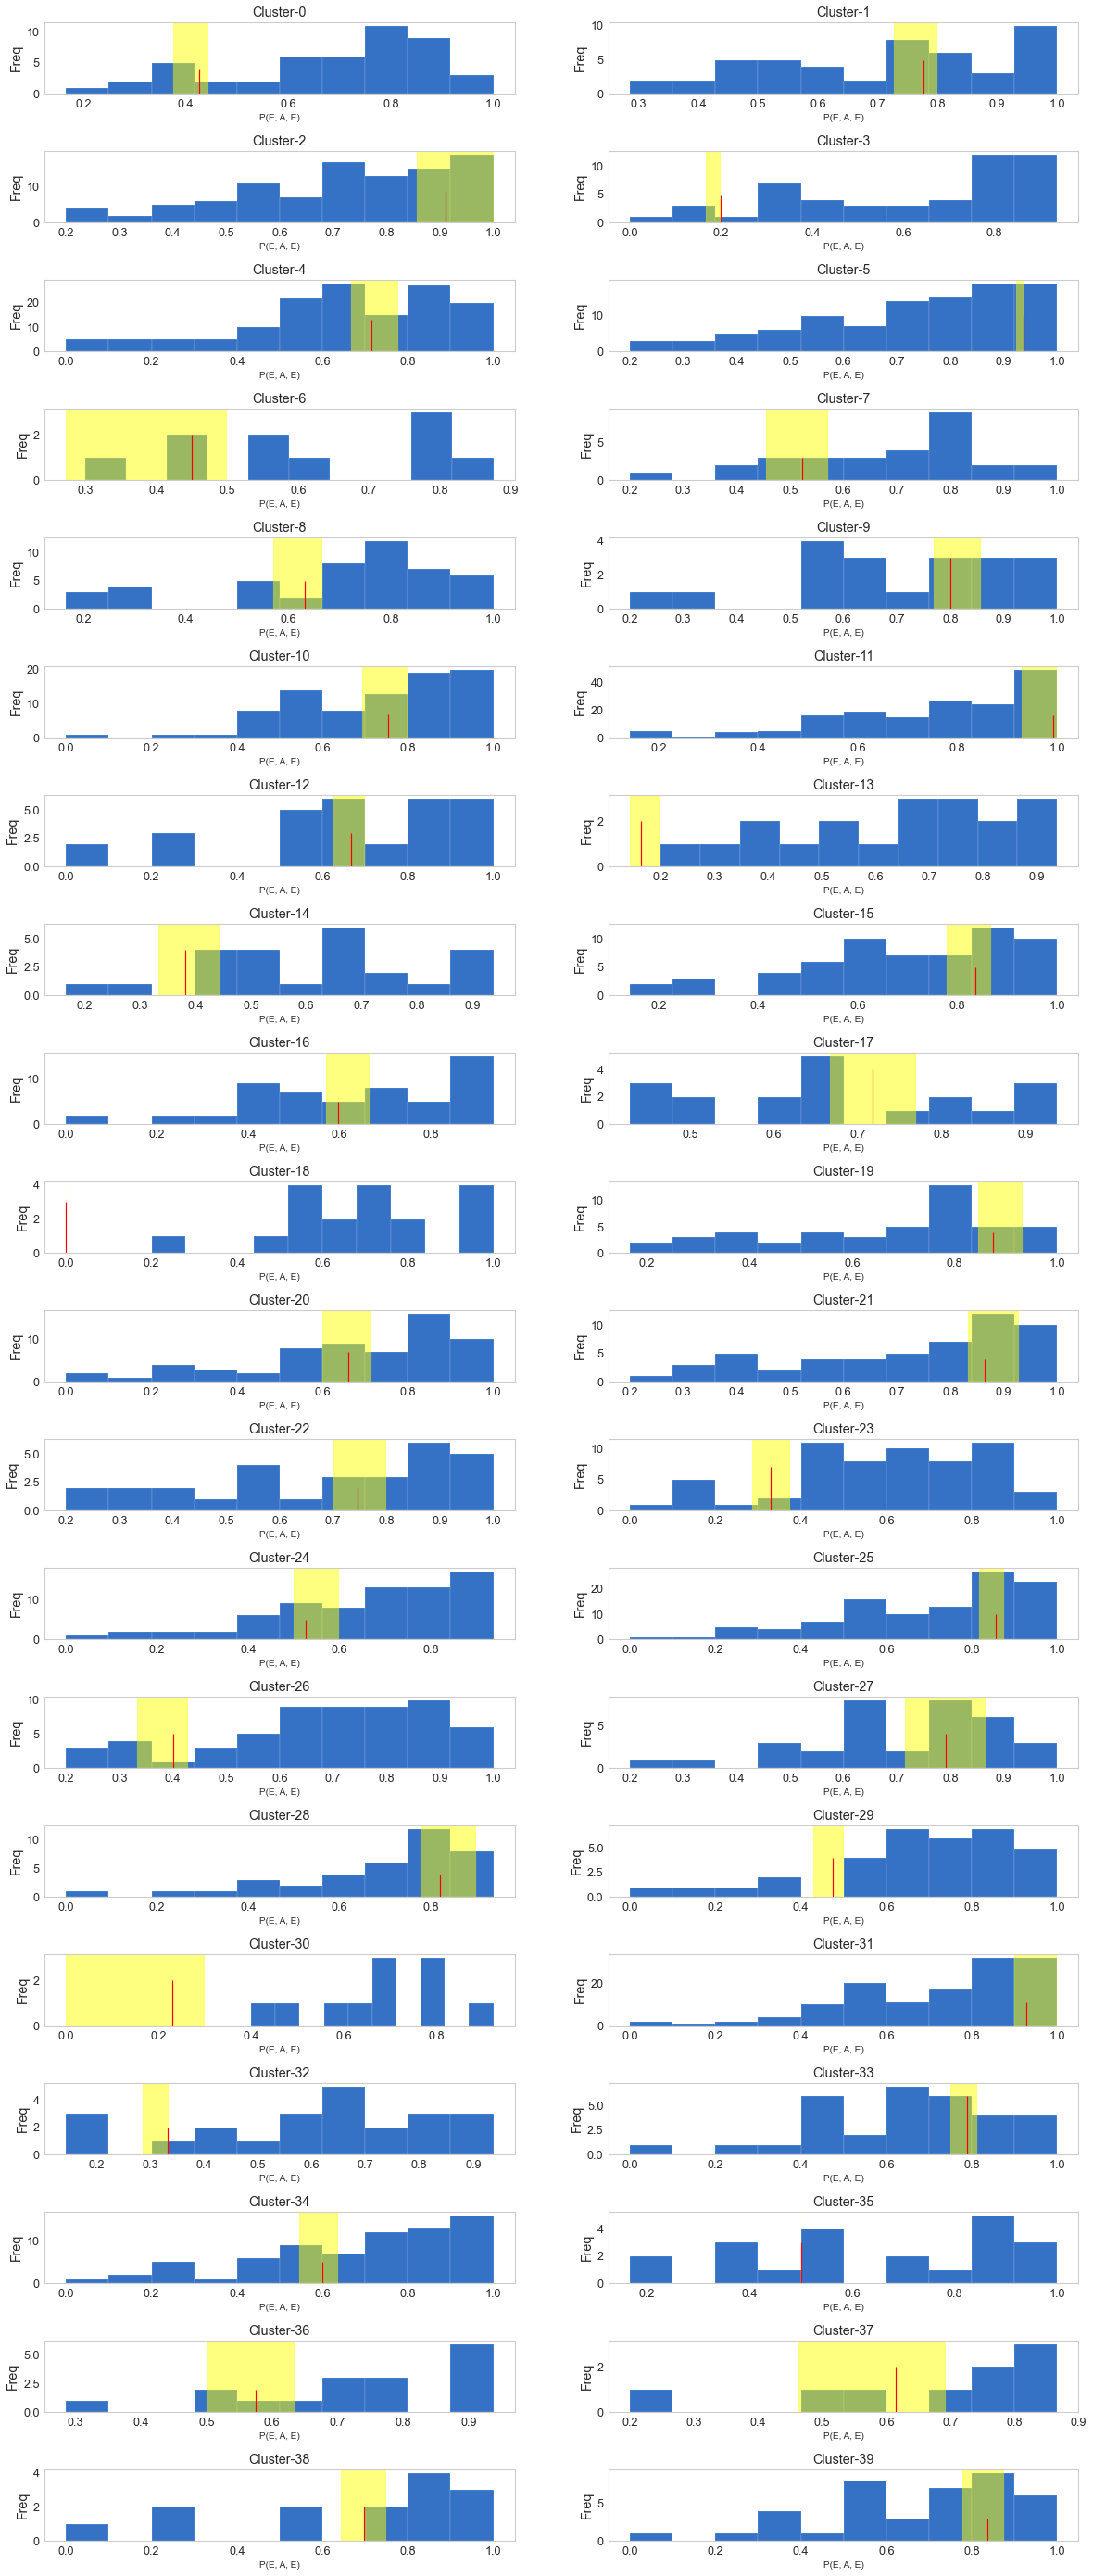

In [216]:
plt.figure(figsize=(20,50))
sns.set_style("whitegrid", {'axes.grid' : False})

for cluster in range(n_clusters):
    plt.subplot(20, 2, cluster+1)
    plt.hist(plot_df[plot_df.fitted_cluster==cluster]['tru-P(L, N, L)'])
    
    pred_prob = plot_df[plot_df.fitted_cluster==cluster]['P(L, N, L)'].iloc[0]
    ymax = plot_df[plot_df.fitted_cluster==cluster]['tru-P(L, N, L)'].value_counts().max()
    plt.vlines(pred_prob, ymin=0, ymax=ymax, colors='red')
#     plt.vlines([X[X.fitted_cluster==cluster]['P(L, N, L)'].min(),
#                 X[X.fitted_cluster==cluster]['P(L, N, L)'].max()], 
#                ymin=[0,0], ymax=[ymax, ymax], colors=['yellow', 'yellow'])
    plt.axvspan(xmin=X[X.fitted_cluster==cluster]['P(L, N, L)'].min(),
               xmax=X[X.fitted_cluster==cluster]['P(L, N, L)'].max(),
               ymin=0, ymax=ymax, alpha=0.5, color='yellow')
    plt.xlabel('P(E, A, E)', fontsize=10)
    plt.ylabel('Freq')
    plt.gca().set_title(f'Cluster-{cluster}')
    plt.subplots_adjust(
                    hspace=0.8, 
                    )
plt.show()